<a href="https://colab.research.google.com/github/tnwls6865/Creative_Masters/blob/main/week10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creative Masters

## Colab 환경 세팅

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


In [2]:
# HIDE OUTPUT
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents
  !pip install -q pygame

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-xkb-utils
  xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-utils
  x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 24 not upgraded.
Need to get 7,920 kB of archives.
After this operation, 12.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxfont2 amd64 1:2.0.3-1 [91.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libxkbfile1 amd64 1

Q-Learning에서는 Q-table에 환경이 취할 수 있는 모든 가능한 상태에 대한 항목이 포함되어 있어야 합니다. 기존의 Q-러닝은 환경에 소수의 개별 상태 요소만 포함된 경우 좋은 학습 알고리즘이 될 수 있습니다. 그러나 상태 공간이 크면 Q-table이 엄청나게 커질 수 있습니다.

대규모 state 공간에 대한 policy 생성은 DQN(Deep Q-Learning Networks)이 일반적으로 처리할 수 있는 작업입니다. 신경망은 이러한 상태를 일반화하고 공통점을 학습할 수 있습니다. 테이블과 달리 신경망은 상태와 작업의 모든 조합을 나타내는 프로그램이 필요하지 않습니다. DQN은 각 가능한 행동에 대한 예상 보상을 반환함으로써 상태를 받아들이고 action을 제안하는 방식으로 구성되어 있습니다. 다음 그림은 DQN 구조와 상태와 Action 간의 매핑을 보여줍니다.

**Figure 12.DQL: Deep Q-Learning (DQL)*
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/deepqlearning.png "Reinforcement Learning")

In [3]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

이 예제를 Colab에서 실행할 수 있도록 임베디드 비디오를 출력할 가상 디스플레이를 사용합니다. 노트북 외부에서 이 코드를 실행하는 경우 가상 디스플레이를 생략하고 window에 직접 애니메이션을 적용할 수 있습니다.

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyper-parameter setting

In [5]:
# How long should training run?
num_iterations = 20000
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000
# How many steps should we run each iteration to collect
# data from.
collect_steps_per_iteration = 1
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
# How often should the program provide an update.
log_interval = 200

# How many episodes should the program use for each evaluation.
num_eval_episodes = 10
# How often should an evaluation occur.
eval_interval = 1000

## Environment

이번 실습은 CartPole로 진행하겠습니다.

마찰이 없는 트랙에 카트 (cart)가 하나 있습니다. 카트에는 막대기 (pole)가 하나 연결되어 있고, 이 연결부는 조작되지 않습니다. 대신, 카트에 +1 또는 -1의 힘을 인가함으로써 조절됩니다. 막대기가 세워진 상태로 게임이 시작되며, 목표는 넘어지지 않도록 하는 것입니다. 막대기가 제대로 서있으면 매 시간 스텝마다 +1의 보상 이 주어집니다.

에피소드가 종료되는 조건은 아래와 같습니다.

- 막대기가 수직으로부터 12도 이상 기울어짐 (-12도 ~ 12도).
- 카트가 중심으로부터 2.4 이상 벗어남 (-2.4 ~ 2.4).
- 시간 스텝이 200보다 커짐 (CartPole-v1의 경우 500).

In [6]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

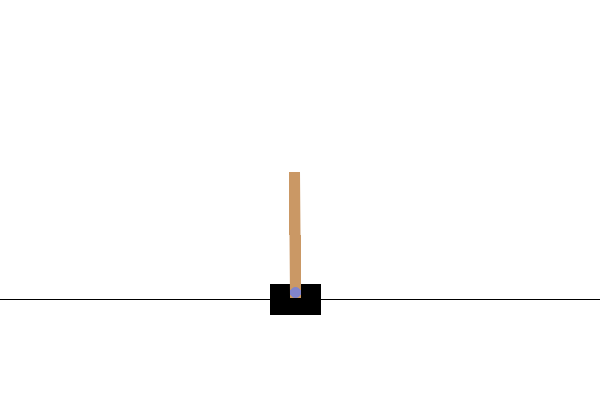

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"

In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.00011699,  0.03602552,  0.01218398,  0.04601482], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.00060352,  0.23097067,  0.01310428, -0.24279918], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


실제 학습시킬 환경과 이를 실험해볼 환경을 따로 구축하겠습니다.

In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [10]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## DQN

TF-Agents는 다양한 에이전트의 표준 구현을 제공합니다. 본 실습에서는 기본적으로 많이 사용되는 DQN을 활용하도록 하겠습니다.

- [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) -> 이번 실습에서 활용
- [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
- [TD3](https://arxiv.org/pdf/1802.09477.pdf)
- [PPO](https://arxiv.org/abs/1707.06347)
- [SAC](https://arxiv.org/abs/1801.01290)

Discrete action space가 있는 환경에서만 DQN 에이전트를 사용할 수 있습니다. DQN은 환경에서 주어진 상태에서 모든 작업에 대한 Q-값(예상 수익)을 예측하는 방법을 학습하는 신경망 모델인 Q-Network를 사용합니다.

다음 코드는 **tf_agents.networks.q_network**를 사용하여 QNetwork를 만들고 **observation_spec**, **action_spec** 및 모델의 숨겨진 레이어의 수와 크기를 설명하는 튜플을 전달합니다.

In [11]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [12]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

Policy는 agent가 환경에서 작동하는 방식을 정의합니다. 일반적으로 강화 학습은 policy가 원하는 결과를 생성할 때까지 기본 모델을 학습하는 것을 목표로 합니다.

Agents contain two policies: 

*  **agent.policy** -  The algorithm uses this main policy for evaluation and deployment.
* **agent.collect_policy** - The algorithm this secondary policy for data collection.


In [13]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [14]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [15]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## Metrcis and Evaluation

Policy를 평가하는 데 사용되는 가장 일반적인 지표는 average return입니다. Return은 에피소드에 대한 environment에서 policy를 실행하는 동안 얻은 reward의 합계입니다. 여러 에피소드가 실행되어 평균 reward을 산출합니다. 다음 함수는 주어진 policy, environment 및 에피소드 수에 따라 평균 reward을 계산합니다.

In [16]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [17]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

20.5

## Replay Buffer & Data Collection

* Replay Buffer는 수집된 데이터를 추적하는 함수입니다.
* 이를 위해 데이터를 수집하는 코드도 작성합니다.

In [18]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [19]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [20]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, \
                                      next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer, steps=100)

In [21]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

## Training

이제 준비를 마쳤으니 본격적으로 학습을 진행하도록 하겠습니다. (약 15분 가량 소요됩니다.)

In [24]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy,
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and 
    # save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update 
    # the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy,
                                        num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 15.176492691040039
step = 400: loss = 3.172837257385254
step = 600: loss = 2.7521090507507324
step = 800: loss = 5.651454448699951
step = 1000: loss = 4.49054479598999
step = 1000: Average Return = 23.5
step = 1200: loss = 12.627233505249023
step = 1400: loss = 35.17498016357422
step = 1600: loss = 41.012474060058594
step = 1800: loss = 51.81326675415039
step = 2000: loss = 36.19181823730469
step = 2000: Average Return = 41.0
step = 2200: loss = 89.0496597290039
step = 2400: loss = 26.515731811523438
step = 2600: loss = 27.03225326538086
step = 2800: loss = 15.822851181030273
step = 3000: loss = 50.7889289855957
step = 3000: Average Return = 59.900001525878906
step = 3200: loss = 19.030651092529297
step = 3400: loss = 85.69596862792969
step = 3600: loss = 7.263143539428711
step = 3800: loss = 130.2899627685547
step = 4000: loss = 97.78639221191406
step = 4000: Average Return = 74.9000015258789
step = 4200: loss = 98.91725158691406
step = 4400: loss = 131.425994873046

## Visualization

(4.174999999999999, 250.0)

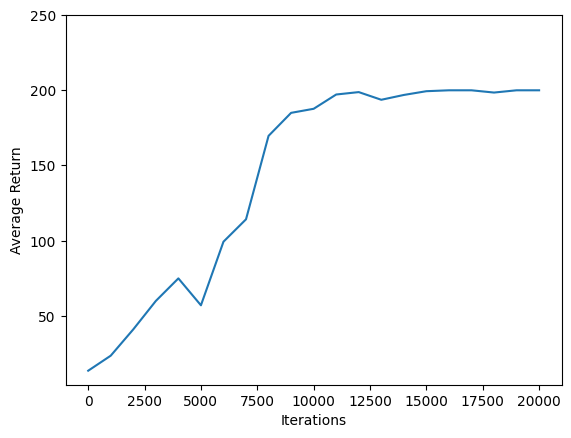

In [25]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

잘 학습이 되었는지 확인까지 해보도록 하겠습니다.

In [26]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [27]:
# HIDE OUTPUT
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")

상대적으로도 잘 된게 맞는지 Random이랑 비교해보도록 하겠습니다.

In [28]:
# HIDE OUTPUT
create_policy_eval_video(random_policy, "random-agent")

다양한 실제 사례들

- https://wandb.ai/mukilan/intro_to_gym/reports/A-Gentle-Introduction-to-OpenAI-Gym--VmlldzozMjg5MTA3
- https://www.youtube.com/watch?v=V1eYniJ0Rnk
- https://huggingface.co/andrewzhang505/sample-factory-2-doom-battle